<a href="https://colab.research.google.com/github/Pigrey/lateral-view-analysis/blob/master/colab_train_val_Grayscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab setting

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/PadChest_DenseNet')

Mounted at /content/gdrive


In [ ]:
import shutil
shutil.copy('/content/gdrive/MyDrive/PadChest_DenseNet/data.zip', '/content')
!unzip data.zip 

Streaming output truncated to the last 5000 lines.
  inflating: data/313295308387106354963293154359407827106_5x22j4.png  
  inflating: data/313295308387106354963293154359407827106_hqkdjz.png  
  inflating: data/313306357972896653991277229940731218362_uik5nq.png  
  inflating: data/313306357972896653991277229940731218362_vymqp4.png  
  inflating: data/313357267337844837268531835567910834668_p3aav2.png  
  inflating: data/313357267337844837268531835567910834668_p3enbk.png  
  inflating: data/313364620706836659368682248231807812623_e218bj.png  
  inflating: data/313364620706836659368682248231807812623_eherq1.png  
  inflating: data/313449709718187306315515049339906379856_i5qnf5.png  
  inflating: data/313469847357846697166635204746048939002_qcg7ie.png  
  inflating: data/31347740617643122889885621350444674280_c5hca6.png  
  inflating: data/31347740617643122889885621350444674280_c5l10h.png  
  inflating: data/313495684700666045594908028537778508930_sxho1l.png  
  inflating: data/3134956847

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
print("============查看GPU信息================")
# 查看GPU信息
!/opt/bin/nvidia-smi
print("==============查看pytorch版本==============")
# 查看pytorch版本
import torch
print(torch.__version__)
print("============查看虚拟机硬盘容量================")
# 查看虚拟机硬盘容量
!df -lh
print("============查看cpu配置================")
# 查看cpu配置
!cat /proc/cpuinfo | grep model\ name
print("=============查看内存容量===============")
# 查看内存容量
!cat /proc/meminfo | grep MemTotal


============查看GPU信息================
Fri Jun 17 17:34:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                    

# Import packages

In [ ]:
import torch
from torch import sigmoid
from torch.nn import Linear
import torch.nn.init as nn_init
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib as matplt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os
from os import path
from sklearn.metrics import roc_auc_score
import datetime
import time

from accuracy_estimation import threshold_classifier
from accuracy_estimation import sample_accuracy
from accuracy_estimation import F1_score
from accuracy_estimation import cat_acc

path_join = path.join

%matplotlib inline

torch.manual_seed(0)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

# User inputs

In [ ]:
ALL_IMAGE_DIR = '/content/data' # directory containing all images
BASE_PATH_LABELS = '/content/gdrive/MyDrive/PadChest_DenseNet/labels' # training, validation and test lists

TRAIN_LISTS = ['train_PADCHEST.csv']
VAL_LISTS = ['val_PADCHEST.csv']
TEST_LIST = ['test_PADCHEST_0.csv']

# Output directory for the training, validation, test statistics
# MODEL_NAME followed by a date-time stamp will be added to 
# MODEL_BASE_PATH
MODEL_BASE_PATH = '/content/gdrive/MyDrive/PadChest_DenseNet/logs/train-val'

MODEL_NAME = 'densenet121'
#MODEL_NAME = 'resnet50'
#MODEL_NAME = 'densenet121attA'
#MODEL_NAME = 'densenet121attB'

# Classes to use for the image labels
# Note: there must be at least 14 classes
CLASSES = ['bone lesion',
        'infiltrates',
        'alveolar pattern',
        'consolidation',
        'interstitial pattern',
        'ground glass pattern',
        'atelectasis',
        'lobar atelectasis',
        'laminar atelectasis',
        'COPD',
        'pleural thickening',
        'apical pleural thickening',
        'calcified pleural thickening',
        'mass',
        'pulmonary mass',
        'granuloma',
        'hilar',
        'adenopathy',
        'vascular hilar enlargement',
        'aortic atheromatosis',
        'aortic elongation',
        'descendent aortic elongation',
        'aortic button enlargement',
        'supra aortic elongation',
        'cardiomegaly']


BATCH_SIZE = 8
# BATCH_SIZE = 16
# BATCH_SIZE = 32

TRAIN_EPOCH = 30

LEARNING_RATE = 0.02        # old learning rate = 0.01
MOMENTUM = 0.9
SEED = 0

REINITIALIZE_METHOD = None; # do not reset pretrained weights
#REINITIALIZE_METHOD = 'xavierNormal'; # reset all weights

# Load training and validation data

In [ ]:
# Set seed
np.random.seed(SEED)
torch.manual_seed(SEED)

CLASSES = np.array(CLASSES)
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, im_dir, im_names, im_labels, im_transforms=None):
        self.im_dir = im_dir
        self.im_labels = im_labels
        self.im_names = im_names
        if im_transforms:
            self.im_transforms = im_transforms
        else:
            self.im_transforms = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        
        return len(self.im_labels)

    def __getitem__(self, idx):
        im_file = os.path.join(self.im_dir,
                               self.im_names[idx])
        #print(im_file)
        im = Image.open(im_file).convert('')    # convert to RGB or Grayscale

        im = self.im_transforms(im)
        
        return im, self.im_labels[idx]

def load_data(all_image_dir, train_lists, base_path_labels, classes, batchsize, im_transforms):
    train_sets = []
    train_loaders = []
    for train_list in train_lists:
        full_path_list = path_join(base_path_labels, train_list)
        df = pd.read_csv(full_path_list)
        im_names = df['image'].to_numpy()
        im_labels = torch.tensor(df[classes].to_numpy(), dtype=torch.float)
        #assert im_labels.shape[1] == n_classes, 'Number of classes from train list not consistent with provided N_CLASSES'
        train_sets.append(CustomDataset(all_image_dir, im_names, im_labels, im_transforms))
        train_loaders.append(DataLoader(train_sets[-1], batch_size=batchsize, shuffle=True))
        print('Size for {0} = {1}'.format(train_list, len(im_names)))
    
    return train_loaders
    
# Load data

im_transforms = transforms.Compose([
    transforms.Resize(227),
    transforms.RandomCrop(227),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(30, interpolation=False, expand=False, center=None, fill=None),
    transforms.ToTensor(),
    # transforms.Grayscale(num_output_channels=1),
    # transforms.Normalize(mean=[0.469, 0.469, 0.469], std=[0.269, 0.269, 0.269])
    transforms.Normalize(mean=[0.462], std=[0.272])
])

# Create training loaders
train_loaders = load_data(ALL_IMAGE_DIR, TRAIN_LISTS, BASE_PATH_LABELS, CLASSES, BATCH_SIZE, im_transforms)
val_loaders = load_data(ALL_IMAGE_DIR, VAL_LISTS, BASE_PATH_LABELS, CLASSES, BATCH_SIZE, im_transforms)

Size for train_PADCHEST.csv = 30313
Size for val_PADCHEST.csv = 12386


# Visualize some training images

Visualize training images ...
Training set 0


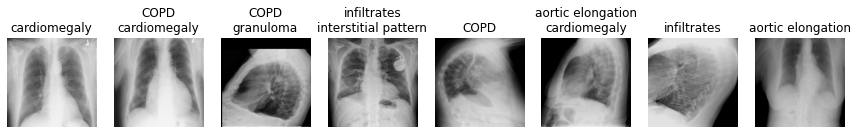

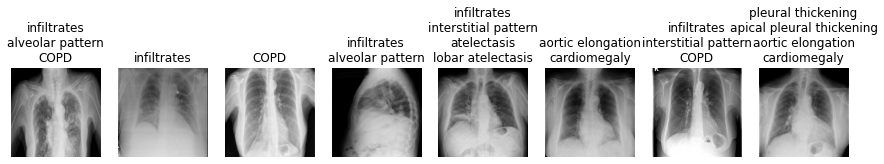

In [ ]:
# Visualize some of the images and show corresponding labels
def show_batch_images(dataloader_iter, classes):
    images, labels = next(dataloader_iter)
    fig, axes = plt.subplots(1, len(images), figsize=(15, 7))
    
    im_mean = torch.tensor([0.469])
    im_std = torch.tensor([0.269])
    
    
    for count, (im, label) in enumerate(zip(images, labels)):
        ax = axes[count]
        im = im.permute(1, 2, 0)
        # un-normalized the image
        im.mul_(im_std).add_(im_mean) # inplace multiplication and addition
        im = im.numpy()
        
        # The normalize code -> t.sub_(m).div_(s)
        ax.imshow(np.squeeze(im), vmin=0, vmax=1, cmap=plt.get_cmap('gray')) 
        ax.axis('off')
        idx = label.nonzero().squeeze(1).numpy()
        if len(idx):
            class_names = classes[idx]
            title = '\n'.join(list(class_names))
        else:
            title = 'No Finding'

        ax.set_title(title)
        
        
print('Visualize training images ...')
for count, loader in enumerate(train_loaders):
    loader_iter = iter(loader)
    print('Training set {0}'.format(count))
    for i in range(2):
        show_batch_images(loader_iter, CLASSES)


# Initialize model

In [ ]:
import importlib

def initialize_model(model_name, reinitialize_method):
    if  'densenet121att' in model_name:
        model_module = importlib.import_module(model_name)
        #print(model_module)
        model = getattr(model_module, model_name)(pretrained=True,
                                                  num_classes=len(CLASSES))
        #model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, len(CLASSES)), 
        #                                 nn.Softmax(dim=1))
        model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, len(CLASSES)), 
                                         nn.Sigmoid())
        # Initialize the weights of the classifier layer 
        print('Initialize weights of classifier layer')
        for m in model.classifier.modules():
            if isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)

    elif 'densenet' in model_name:
        import densenet_models_single
        importlib.reload(densenet_models_single)
        #model = densenet121(pretrained=True)
        model = getattr(densenet_models_single, model_name)(pretrained=False)
        #model.classifier = nn.Sequential(nn.Linear(1024, len(CLASSES)), nn.Softmax(dim=1))
        model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, len(CLASSES)), 
                                         nn.Sigmoid())
        # Initialize the weights of the classifier layer 
        print('Initialize weights of classifier layer')
        for m in model.classifier.modules():
            if isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)

    elif 'resnet' in model_name:
        import resnet_models
        importlib.reload(resnet_models)
        #model = resnet50(pretrained=True)
        model = getattr(resnet_models, model_name)(pretrained=True)
        #model.fc = nn.Sequential(nn.Linear(model.fc.in_features, len(CLASSES)), 
        #                         nn.Softmax(dim=1))
        model.fc = nn.Sequential(nn.Linear(model.fc.in_features, len(CLASSES)), 
                                 nn.Sigmoid())
        # Initialize the weights of the classifier layer 
        print('Initialize weights of classifier layer')
        model_fc = model.fc
        for m in model_fc.modules():
            if isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)
    else:
        raise NotImplementedError('Unknown model name')
        
    if reinitialize_method == None:
        pass
    elif reinitialize_method == 'xavierNormal':
        print('!!!!!! Reinitialize weights with xavier normal !!!!!!')
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                nn_init.xavier_normal_(m.weight, gain=1)
                if m.bias is not None:
                    nn_init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn_init.normal_(m.weight, 0, 0.01)
                nn_init.constant_(m.bias, val=0.)
            elif isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)
                if m.bias is not None:
                    nn_init.constant_(m.bias, val=0.)
    else:
        raise NotImplementedError('Unknown initialization method')
        
        
    return model 

model = initialize_model(MODEL_NAME, REINITIALIZE_METHOD)


loader_iter = iter(train_loaders[0])
images, labels = next(loader_iter)


print('{0} model output test'.format(MODEL_NAME))
#print(images[0, 0, 0, :5])
y_hat = model(images)
n_params = sum(p.numel() for p in model.parameters())
print('number of parameters = ', n_params)
print(y_hat[0])


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Initialize weights of classifier layer
densenet121 model output test
number of parameters =  6979481
tensor([0.7311, 0.1677, 0.2369, 0.2788, 0.8572, 0.2897, 0.5019, 0.3368, 0.3003,
        0.3823, 0.4979, 0.3585, 0.4238, 0.5906, 0.8830, 0.2378, 0.4124, 0.2452,
        0.8261, 0.6113, 0.4727, 0.6906, 0.4151, 0.5649, 0.6053],
       grad_fn=<SelectBackward0>)


# Train model on training set followed by evaluation on validation set of each split

## Grayscale, augmentation, learning rate = 0.01


********Split =  0 , training model ...
Initialize weights of classifier layer
Split 0, Epoch 0, Batch 1/948: elapsed 0.88s,batch loss 0.799198, curr mean epoch loss 0.799198
Sample Accuracy: 0.00%, Precision: 0.07, Recall: 1.00, F1:1.00
Split 0, Epoch 0, Batch 401/948: elapsed 129.14s,batch loss 0.189957, curr mean epoch loss 0.227815
Sample Accuracy: 7.02%, Precision: 0.25, Recall: 0.46, F1:0.46
Split 0, Epoch 0, Batch 801/948: elapsed 257.44s,batch loss 0.197202, curr mean epoch loss 0.219126
Sample Accuracy: 7.76%, Precision: 0.29, Recall: 0.45, F1:0.45
Epoch 0: elapsed 304.80s, curr mean epoch loss=0.217583,curr average auroc=0.636144
Class auroc =  {'bone lesion': 0.519, 'infiltrates': 0.692, 'alveolar pattern': 0.743, 'consolidation': 0.58, 'interstitial pattern': 0.579, 'ground glass pattern': 0.622, 'atelectasis': 0.58, 'lobar atelectasis': 0.505, 'laminar atelectasis': 0.529, 'COPD': 0.701, 'pleural thickening': 0.577, 'apical pleural thickening': 0.603, 'calcified pleural t

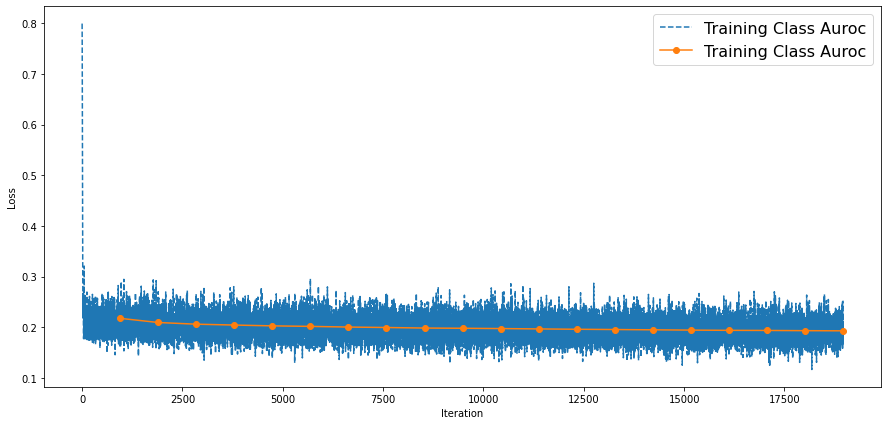

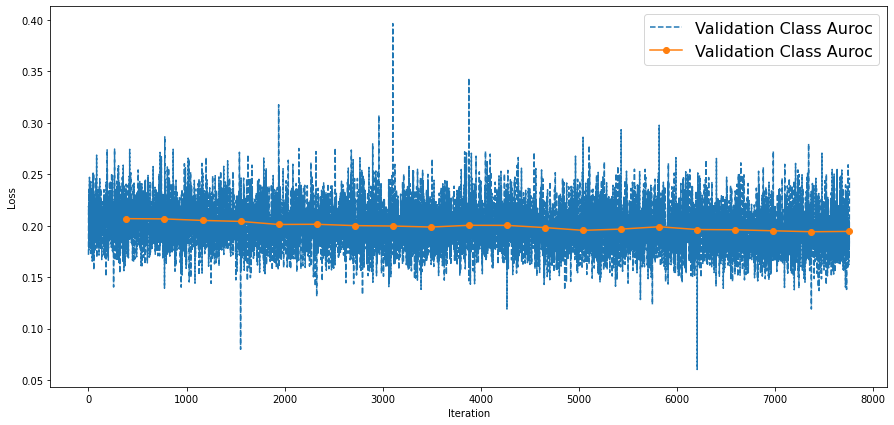

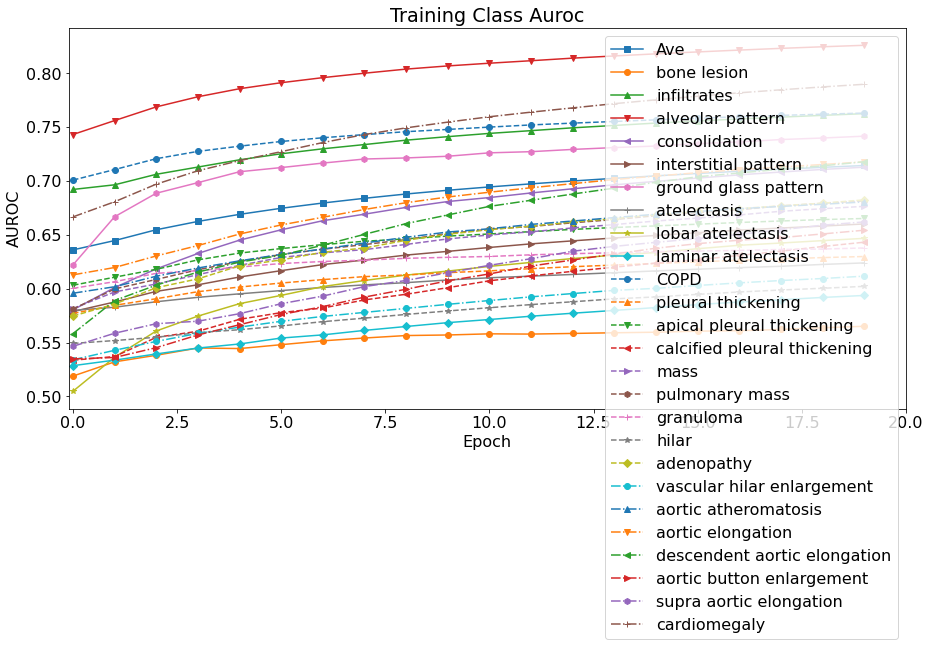

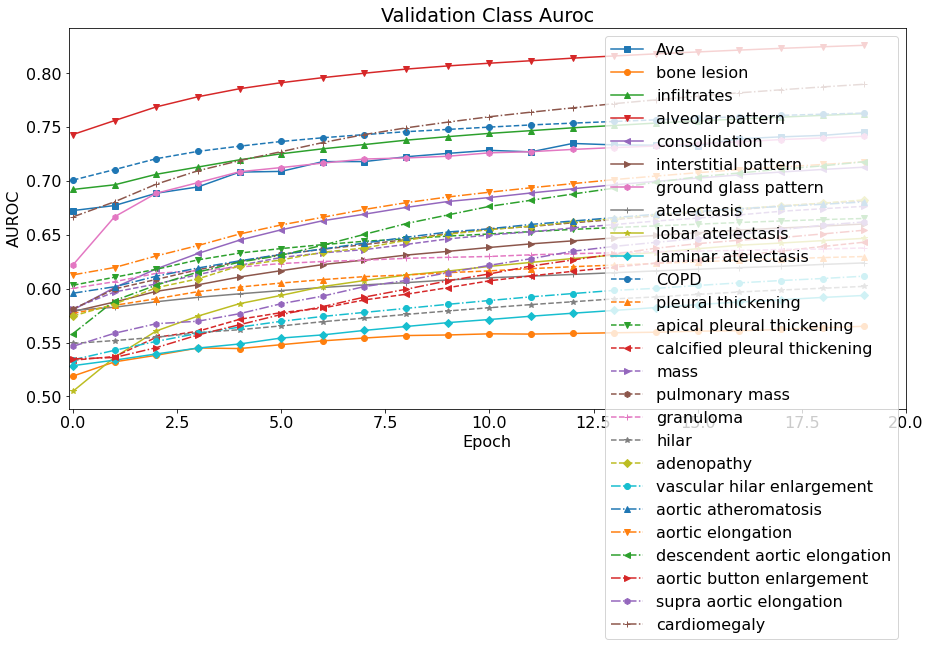

In [ ]:
def make_dir_if_not_exist(folder):
    try:
        os.makedirs(folder)
    except:
        pass

def train_model(model, train_loader, device, n_epoch, optimizer, criterion, model_base_path, split=0):
    start_time = time.time()

    model.train() # prep model for training

    n_batches = len(train_loader)
    Ypred = []
    Ytruth = []
    stats = {'all_loss': [], 'epoch_end_ind': [], 'epoch_loss': [],
             'epoch_auroc_ave': [], 'epoch_auroc_classes': [], 'sample_accuracy': [],
             'precision': [], 'recall': [], 'F1': []}
    val_temp = {'all_loss': [], 'epoch_end_ind': [], 'epoch_loss': [],
             'epoch_auroc_ave': [], 'epoch_auroc_classes': [], 'sample_accuracy': [],
             'precision': [], 'recall': [], 'F1': []}

    #max_count = 2; # for debugging

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        total, correct, tp_total, fp_total, fn_total = 0, 0, 0, 0, 0
        for count, (data, target) in enumerate(train_loader):

            data = data.to(device)
            target = target.to(device)
            # data = data.to(device)

            # Step 1. clear gradients
            optimizer.zero_grad()
            # Step 2. perform forward pass using `model`, save the output to y_hat;
            # Convert output to probability vector using softmax function
            ypred = model(data)
            # ypred = nn.sigmoid(ypred)
            Ypred.append(ypred.detach().cpu().numpy())
            Ytruth.append(target.detach().cpu().numpy())
            # Step 3. calculate the loss using `criterion`, save the output to loss.
            loss = criterion(ypred, target)
            # Step 4. backward pass
            loss.backward()
            # Step 5. optimization
            optimizer.step()
            # Step 6. record loss
            loss_scalar = float(loss.detach().cpu().numpy())
            curr_epoch_loss.append(loss_scalar)
            stats['all_loss'].append(loss_scalar)

            y_0_1 = threshold_classifier(ypred, 0.55)
            correct_num, y_size = sample_accuracy(y_0_1, target)
            total += y_size
            correct += correct_num

            tp, fp, fn = F1_score(y_0_1, target)
            tp_total += tp
            fp_total += fp
            fn_total += fn

            train_pre = tp_total / (tp_total + fp_total + 1e-8)
            train_rec = tp_total / (tp_total + fn_total + 1e-8)
            train_F1 = 2 * (train_pre * train_rec) / (train_pre + train_rec + 1e-8)

            if count % 400 == 0:
                print('Split {0}, Epoch {1}, Batch {2}/{3}: elapsed {4:.2f}s,'
                      'batch loss {5:g}, curr mean epoch loss {6:g}'
                      ''.format(split, epoch, count + 1, n_batches, time.time() - start_time,
                                loss_scalar, np.mean(curr_epoch_loss)))
                print('Sample Accuracy: {0:.2f}%, Precision: {1:.2f}, Recall: {2:.2f}, F1:{2:.2f}'
                              ''.format(100*correct/total, train_pre, train_rec, train_F1))

            # for debugging
            #if count >= max_count:
            #    break

        stats['sample_accuracy'].append(correct/total)
        stats['precision'].append(train_pre)
        stats['recall'].append(train_rec)
        stats['F1'].append(train_F1)
        Ypred1 = np.concatenate(Ypred, axis=0)
        Ytruth1 = np.concatenate(Ytruth, axis=0)
        try:
            auroc_ave =  roc_auc_score(Ytruth1, Ypred1, average='weighted')
            auroc_classes = roc_auc_score(Ytruth1, Ypred1, average=None)
        except ValueError:
            print('WARNING: AUC undefined as only one sample is available for 1 or more of the classes')
            auroc_ave = 0.0
            auroc_classes = np.zeros(target.shape[1])

        stats['epoch_auroc_ave'].append(auroc_ave)
        stats['epoch_auroc_classes'].append(auroc_classes)
        stats['epoch_end_ind'].append(len(stats['all_loss'])-1)
        mean_epoch_loss = np.mean(curr_epoch_loss)
        stats['epoch_loss'].append(mean_epoch_loss)
        print('Epoch {0}: elapsed {1:.2f}s, curr mean epoch loss={2:g},'
              'curr average auroc={3:g}'.format(epoch, time.time() - start_time,
                                              mean_epoch_loss, auroc_ave))
        auroc_classes_dict = dict(zip(CLASSES, np.round(auroc_classes, 3)))
        print('Class auroc = ', auroc_classes_dict)
        print('Saving model ...')

        model_file = path_join(model_base_path, '_epoch' + str(epoch))    # 'model_split'+str(split)+
        torch.save(model.state_dict(), model_file)
        # for debugging
        #if count >= 3:
        #    break

        val_temp = eval_model(model, val_temp, val_loader, DEVICE)

    return model, stats, val_temp



def eval_model(model, val_temp, dataloader, device):

    model.eval()
    Ypred = []
    Ytruth = []
    curr_epoch_loss = []
    val_total, val_correct, val_tp_total, val_fp_total, val_fn_total = 0, 0, 0, 0, 0
    n_batches = len(dataloader)

    #max_count = 3; # for debugging
    for count, (data, truth) in enumerate(dataloader):
        data = data.to(device)
        truth = truth.to(device)
        '''if count % 10 == 0:
            print('Batch {0}/{1}'.format(count+1, n_batches))'''
        ypred = model(data)
        #ypred = ypred.softmax(dim=1)
        Ypred.append(ypred.detach().cpu().numpy())
        Ytruth.append(truth.detach().cpu().numpy())
        #if count >= max_count:
        #    break
        loss = criterion(ypred, truth)
        loss_scalar = float(loss.detach().cpu().numpy())
        curr_epoch_loss.append(loss_scalar)
        val_temp['all_loss'].append(loss_scalar)

        # F1 score
        y_0_1 = threshold_classifier(ypred, 0.55)
        correct_num, y_size = sample_accuracy(y_0_1, truth)
        val_total += y_size
        val_correct += correct_num

        tp, fp, fn = F1_score(y_0_1, truth)
        val_tp_total += tp
        val_fp_total += fp
        val_fn_total += fn

        val_pre = val_tp_total / (val_tp_total + val_fp_total + 1e-8)
        val_rec = val_tp_total / (val_tp_total + val_fn_total + 1e-8)
        val_F1 = 2 * (val_pre * val_rec) / (val_pre + val_rec + 1e-8)


    val_temp['sample_accuracy'].append(val_correct/val_total)
    val_temp['precision'].append(val_pre)
    val_temp['recall'].append(val_rec)
    val_temp['F1'].append(val_F1)

    Ypred = np.concatenate(Ypred, axis=0)
    Ytruth = np.concatenate(Ytruth, axis=0)

    try:
        auroc_ave =  roc_auc_score(Ytruth, Ypred, average='weighted')
        auroc_classes = roc_auc_score(Ytruth, Ypred, average=None)
    except ValueError:
        print('WARNING: AUC undefined as only one sample is available for 1 or more of the classes')
        auroc_ave = 0.0
        auroc_classes = np.zeros(truth.shape[1])

    val_temp['epoch_auroc_ave'].append(auroc_ave)
    val_temp['epoch_auroc_classes'].append(auroc_classes)
    val_temp['epoch_end_ind'].append(len(val_temp['all_loss']) - 1)
    mean_epoch_loss = np.mean(curr_epoch_loss)
    val_temp['epoch_loss'].append(mean_epoch_loss)

    print('Validation: curr mean epoch loss={0:g},'
              'curr average auroc={1:g}'.format(mean_epoch_loss, auroc_ave))
    print('Sample Accuracy: {0:.2f}%, Precision: {1:.2f}, Recall: {2:.2f}, F1:{2:.2f}'
                              ''.format(100*val_correct/val_total, val_pre, val_rec, val_F1))
    return val_temp


criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

n_epochs = TRAIN_EPOCH

datetime1 = datetime.datetime

# Directory for saving the models and output stats
time_stamp = datetime1.now().strftime("%Y-%m-%d-%H-%M-%S")
model_dir = MODEL_BASE_PATH + '-' + MODEL_NAME + '-' + time_stamp + 'lr_{0:.2f}_channel_{1:.2f}'.format(LEARNING_RATE, 1)
make_dir_if_not_exist(model_dir)

# Copy this Python script to the output directory
#this_file = path.basename(__file__)
#from shutil import copyfile
#copyfile(__file__, path_join(model_dir, this_file))

#val_stats = pd.DataFrame(columns=['Split', 'Ave AUROC', *CLASSES])
val_stats = pd.DataFrame(columns=['Split', 'Epoch', 'Epoch_loss', 'Epoch_AUROC', 'Sample Acc', 'Precision', 'Recall', 'F1',  *CLASSES])
train_stats = pd.DataFrame(columns=['Split', 'Epoch', 'Epoch_loss', 'Epoch_AUROC', 'Sample Acc', 'Precision', 'Recall', 'F1',  *CLASSES])
train_loss = pd.DataFrame(columns=['Split', 'Batch_loss'])
val_loss = pd.DataFrame(columns=['Split', 'Batch_loss'])

fig1, ax1 = plt.subplots(figsize=(15, 7))
fig3, ax3 = plt.subplots(figsize=(15, 7))
matplt.rcParams.update({'font.size': 16})
lnstyles = ['-o', '-^', '-v', '-<', '->', '-h', '-+', '-*', '-D',
            '--o', '--^', '--v', '--<', '-->', '--h', '--+', '--*', '--D',
            '-.o', '-.^', '-.v', '-.<', '-.>', '-.h', '-.+', '-.*', '-.D']

for split, (train_loader, val_loader) in enumerate(zip(train_loaders, val_loaders)):
    print('\n********Split = ', split, ', training model ...')
    # Train model
    start_time_tot = time.time()

    # Re-initialize model for every split
    model = initialize_model(MODEL_NAME, REINITIALIZE_METHOD)


    # Must reset optimizer whenever model is re-initialized
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    #optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        model.cuda()


    model, stats, val_temp = train_model(model, train_loader, DEVICE, n_epochs,
                               optimizer, criterion, model_dir, split)
    print('Total training time {0:.2f}s'.format(time.time() - start_time_tot))

    # Save training stats in data frame
    row_start = split*n_epochs
    row_end = (split+1)*n_epochs
    for count, row in enumerate(range(row_start, row_end)):
        train_stats.loc[row] = [split, count, stats['epoch_loss'][count], stats['epoch_auroc_ave'][count], stats['sample_accuracy'][count], stats['precision'][count], stats['recall'][count], stats['F1'][count],
                                *list(stats['epoch_auroc_classes'][count])]
    out_file = path_join(model_dir, 'train_stats.csv')

    train_stats.to_csv(out_file, index=False)
    print(train_stats)
    train_loss = train_loss.append(pd.DataFrame({'Split': split, 'Batch_loss': stats['all_loss']}))
    out_file = path_join(model_dir, 'train_loss.csv')
    train_loss.to_csv(out_file)

    # Plot training statistics
    train_str_prefix = 'Training Class Auroc'
    iterx = np.arange(len(stats['all_loss']))
    epoch_end_ind = np.array(stats['epoch_end_ind'])
    ax1.plot(iterx, stats['all_loss'], '--', label=train_str_prefix)
    ax1.plot(iterx[epoch_end_ind], stats['epoch_loss'], 'o-', label=train_str_prefix)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'train_loss.png')
    fig1.savefig(out_file)

    fig2, ax2 = plt.subplots(figsize=(15, 7))
    epochs = np.arange(n_epochs)
    ax2.plot(epochs, stats['epoch_auroc_ave'], 's-', label='Ave')
    for jj, name in enumerate(CLASSES):
        ax2.plot(epochs, train_stats.loc[train_stats['Split']==split, name],
                lnstyles[jj], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim(-0.1, n_epochs)
    ax2.set_ylabel('AUROC')
    ax2.set_title(train_str_prefix)
    ax2.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'split'+str(split)+'_train_auroc.png')
    fig2.savefig(out_file)
    # Validate model
    start_time_tot = time.time()
    print('\n********Validating model ...')
    '''auroc_ave, auroc_classes = eval_model(model, val_loader, DEVICE)
    print('Total validation time {0:.2f}s'.format(time.time() - start_time_tot))'''
    #print('Val average auroc={0:g}'.format(auroc_ave))
    #auroc_classes_dict = dict(zip(CLASSES, np.round(auroc_classes,3)))
    #print('Val class auroc=', auroc_classes_dict)

    # Save validation stats in data frame
    row_start = split * n_epochs
    row_end = (split + 1) * n_epochs
    for count, row in enumerate(range(row_start, row_end)):
        val_stats.loc[row] = [split, count, val_temp['epoch_loss'][count], val_temp['epoch_auroc_ave'][count], val_temp['sample_accuracy'][count], val_temp['precision'][count], val_temp['recall'][count], val_temp['F1'][count],
                                *list(val_temp['epoch_auroc_classes'][count])]
    out_file = path_join(model_dir, 'val_stats.csv')

    val_stats.to_csv(out_file, index=False)
    print(val_stats)
    val_loss = val_loss.append(pd.DataFrame({'Split': split, 'Batch_loss': val_temp['all_loss']}))
    out_file = path_join(model_dir, 'val_loss.csv')
    val_loss.to_csv(out_file)

    # Plot validation statistics
    val_str_prefix = 'Validation Class Auroc'
    iterx = np.arange(len(val_temp['all_loss']))
    epoch_end_ind = np.array(val_temp['epoch_end_ind'])
    ax3.plot(iterx, val_temp['all_loss'], '--', label=val_str_prefix)
    ax3.plot(iterx[epoch_end_ind], val_temp['epoch_loss'], 'o-', label=val_str_prefix)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Loss')
    ax3.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'val_loss.png')
    fig3.savefig(out_file)

    fig4, ax4 = plt.subplots(figsize=(15, 7))
    epochs = np.arange(n_epochs)
    ax4.plot(epochs, val_temp['epoch_auroc_ave'], 's-', label='Ave')
    for jj, name in enumerate(CLASSES):
        ax4.plot(epochs, train_stats.loc[train_stats['Split'] == split, name],
                 lnstyles[jj], label=name)
    ax4.set_xlabel('Epoch')
    ax4.set_xlim(-0.1, n_epochs)
    ax4.set_ylabel('AUROC')
    ax4.set_title(val_str_prefix)
    ax4.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'split' + str(split) + '_val_auroc.png')
    fig4.savefig(out_file)
    # Validate model
    '''start_time_tot = time.time()
    print('\n********Validating model ...')
    auroc_ave, auroc_classes = eval_model(model, val_loader, DEVICE)
    print('Total validation time {0:.2f}s'.format(time.time() - start_time_tot))

    # Save validation stats in a data frame
    val_stats.loc[split] = [split, auroc_ave, *auroc_classes]
    out_file = path_join(model_dir, 'val_stats.csv')
    # Stack the class AUROC
    val_stats_stacked = pd.melt(val_stats, id_vars=['Split'], var_name='Class', value_name='AUROC')
    val_stats_stacked.to_csv(out_file, index=False)
    # print(val_stats_stacked.loc[val_stats_stacked['Split']==split])
    print(val_stats_stacked)'''

## Grayscale, **no** augmentation, learning rate = 0.01


********Split =  0 , training model ...
Initialize weights of classifier layer
Split 0, Epoch 0, Batch 1/948: elapsed 0.86s,batch loss 0.77495, curr mean epoch loss 0.77495
Sample Accuracy: 0.00%, Precision: 0.07, Recall: 0.98, F1:0.98
Split 0, Epoch 0, Batch 401/948: elapsed 129.14s,batch loss 0.200351, curr mean epoch loss 0.22843
Sample Accuracy: 7.31%, Precision: 0.26, Recall: 0.46, F1:0.46
Split 0, Epoch 0, Batch 801/948: elapsed 257.54s,batch loss 0.212777, curr mean epoch loss 0.217888
Sample Accuracy: 8.50%, Precision: 0.29, Recall: 0.45, F1:0.45
Epoch 0: elapsed 304.89s, curr mean epoch loss=0.216255,curr average auroc=0.645847
Class auroc =  {'bone lesion': 0.526, 'infiltrates': 0.702, 'alveolar pattern': 0.762, 'consolidation': 0.594, 'interstitial pattern': 0.576, 'ground glass pattern': 0.615, 'atelectasis': 0.589, 'lobar atelectasis': 0.574, 'laminar atelectasis': 0.522, 'COPD': 0.714, 'pleural thickening': 0.596, 'apical pleural thickening': 0.599, 'calcified pleural th

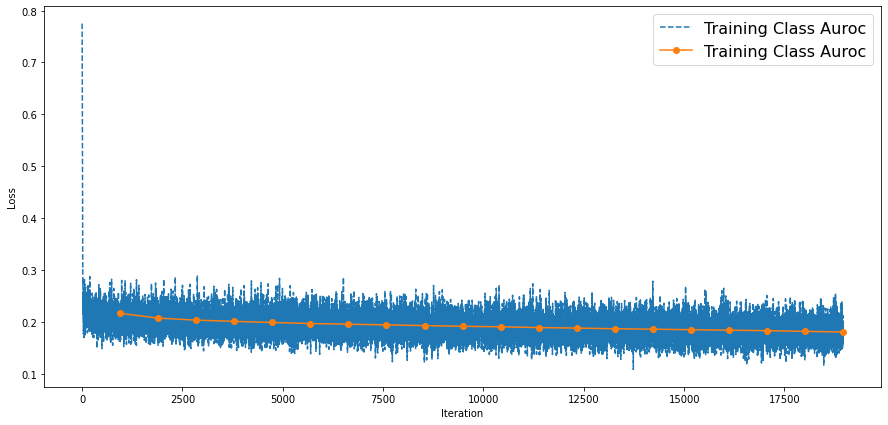

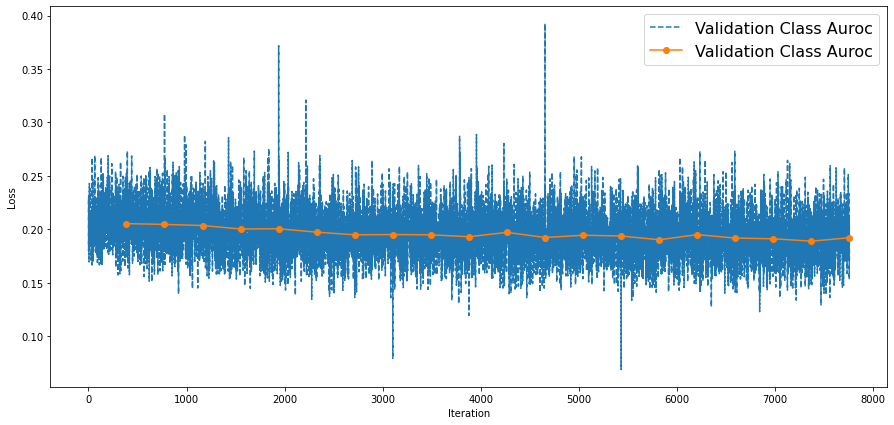

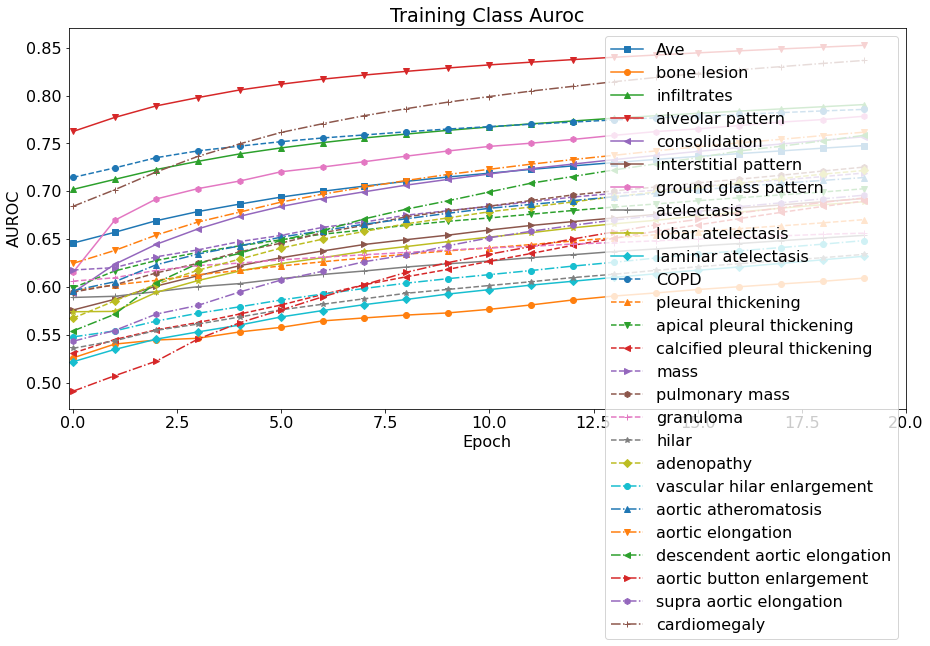

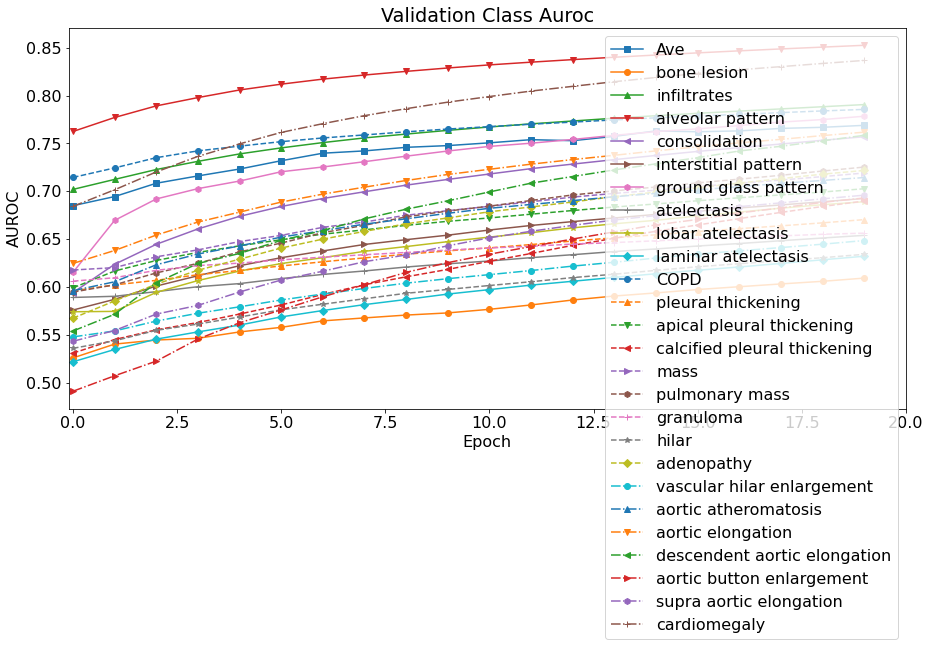

In [ ]:
def make_dir_if_not_exist(folder):
    try:
        os.makedirs(folder)
    except:
        pass

def train_model(model, train_loader, device, n_epoch, optimizer, criterion, model_base_path, split=0):
    start_time = time.time()

    model.train() # prep model for training

    n_batches = len(train_loader)
    Ypred = []
    Ytruth = []
    stats = {'all_loss': [], 'epoch_end_ind': [], 'epoch_loss': [],
             'epoch_auroc_ave': [], 'epoch_auroc_classes': [], 'sample_accuracy': [],
             'precision': [], 'recall': [], 'F1': []}
    val_temp = {'all_loss': [], 'epoch_end_ind': [], 'epoch_loss': [],
             'epoch_auroc_ave': [], 'epoch_auroc_classes': [], 'sample_accuracy': [],
             'precision': [], 'recall': [], 'F1': []}

    #max_count = 2; # for debugging

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        total, correct, tp_total, fp_total, fn_total = 0, 0, 0, 0, 0
        for count, (data, target) in enumerate(train_loader):

            data = data.to(device)
            target = target.to(device)
            # data = data.to(device)

            # Step 1. clear gradients
            optimizer.zero_grad()
            # Step 2. perform forward pass using `model`, save the output to y_hat;
            # Convert output to probability vector using softmax function
            ypred = model(data)
            # ypred = nn.sigmoid(ypred)
            Ypred.append(ypred.detach().cpu().numpy())
            Ytruth.append(target.detach().cpu().numpy())
            # Step 3. calculate the loss using `criterion`, save the output to loss.
            loss = criterion(ypred, target)
            # Step 4. backward pass
            loss.backward()
            # Step 5. optimization
            optimizer.step()
            # Step 6. record loss
            loss_scalar = float(loss.detach().cpu().numpy())
            curr_epoch_loss.append(loss_scalar)
            stats['all_loss'].append(loss_scalar)

            y_0_1 = threshold_classifier(ypred, 0.55)
            correct_num, y_size = sample_accuracy(y_0_1, target)
            total += y_size
            correct += correct_num

            tp, fp, fn = F1_score(y_0_1, target)
            tp_total += tp
            fp_total += fp
            fn_total += fn

            train_pre = tp_total / (tp_total + fp_total + 1e-8)
            train_rec = tp_total / (tp_total + fn_total + 1e-8)
            train_F1 = 2 * (train_pre * train_rec) / (train_pre + train_rec + 1e-8)

            if count % 400 == 0:
                print('Split {0}, Epoch {1}, Batch {2}/{3}: elapsed {4:.2f}s,'
                      'batch loss {5:g}, curr mean epoch loss {6:g}'
                      ''.format(split, epoch, count + 1, n_batches, time.time() - start_time,
                                loss_scalar, np.mean(curr_epoch_loss)))
                print('Sample Accuracy: {0:.2f}%, Precision: {1:.2f}, Recall: {2:.2f}, F1:{2:.2f}'
                              ''.format(100*correct/total, train_pre, train_rec, train_F1))

            # for debugging
            #if count >= max_count:
            #    break

        stats['sample_accuracy'].append(correct/total)
        stats['precision'].append(train_pre)
        stats['recall'].append(train_rec)
        stats['F1'].append(train_F1)
        Ypred1 = np.concatenate(Ypred, axis=0)
        Ytruth1 = np.concatenate(Ytruth, axis=0)
        try:
            auroc_ave =  roc_auc_score(Ytruth1, Ypred1, average='weighted')
            auroc_classes = roc_auc_score(Ytruth1, Ypred1, average=None)
        except ValueError:
            print('WARNING: AUC undefined as only one sample is available for 1 or more of the classes')
            auroc_ave = 0.0
            auroc_classes = np.zeros(target.shape[1])

        stats['epoch_auroc_ave'].append(auroc_ave)
        stats['epoch_auroc_classes'].append(auroc_classes)
        stats['epoch_end_ind'].append(len(stats['all_loss'])-1)
        mean_epoch_loss = np.mean(curr_epoch_loss)
        stats['epoch_loss'].append(mean_epoch_loss)
        print('Epoch {0}: elapsed {1:.2f}s, curr mean epoch loss={2:g},'
              'curr average auroc={3:g}'.format(epoch, time.time() - start_time,
                                              mean_epoch_loss, auroc_ave))
        auroc_classes_dict = dict(zip(CLASSES, np.round(auroc_classes, 3)))
        print('Class auroc = ', auroc_classes_dict)
        print('Saving model ...')

        model_file = path_join(model_base_path, '_epoch' + str(epoch))    # 'model_split'+str(split)+
        torch.save(model.state_dict(), model_file)
        # for debugging
        #if count >= 3:
        #    break

        val_temp = eval_model(model, val_temp, val_loader, DEVICE)

    return model, stats, val_temp



def eval_model(model, val_temp, dataloader, device):

    model.eval()
    Ypred = []
    Ytruth = []
    curr_epoch_loss = []
    val_total, val_correct, val_tp_total, val_fp_total, val_fn_total = 0, 0, 0, 0, 0
    n_batches = len(dataloader)

    #max_count = 3; # for debugging
    for count, (data, truth) in enumerate(dataloader):
        data = data.to(device)
        truth = truth.to(device)
        '''if count % 10 == 0:
            print('Batch {0}/{1}'.format(count+1, n_batches))'''
        ypred = model(data)
        #ypred = ypred.softmax(dim=1)
        Ypred.append(ypred.detach().cpu().numpy())
        Ytruth.append(truth.detach().cpu().numpy())
        #if count >= max_count:
        #    break
        loss = criterion(ypred, truth)
        loss_scalar = float(loss.detach().cpu().numpy())
        curr_epoch_loss.append(loss_scalar)
        val_temp['all_loss'].append(loss_scalar)

        # F1 score
        y_0_1 = threshold_classifier(ypred, 0.55)
        correct_num, y_size = sample_accuracy(y_0_1, truth)
        val_total += y_size
        val_correct += correct_num

        tp, fp, fn = F1_score(y_0_1, truth)
        val_tp_total += tp
        val_fp_total += fp
        val_fn_total += fn

        val_pre = val_tp_total / (val_tp_total + val_fp_total + 1e-8)
        val_rec = val_tp_total / (val_tp_total + val_fn_total + 1e-8)
        val_F1 = 2 * (val_pre * val_rec) / (val_pre + val_rec + 1e-8)


    val_temp['sample_accuracy'].append(val_correct/val_total)
    val_temp['precision'].append(val_pre)
    val_temp['recall'].append(val_rec)
    val_temp['F1'].append(val_F1)

    Ypred = np.concatenate(Ypred, axis=0)
    Ytruth = np.concatenate(Ytruth, axis=0)

    try:
        auroc_ave =  roc_auc_score(Ytruth, Ypred, average='weighted')
        auroc_classes = roc_auc_score(Ytruth, Ypred, average=None)
    except ValueError:
        print('WARNING: AUC undefined as only one sample is available for 1 or more of the classes')
        auroc_ave = 0.0
        auroc_classes = np.zeros(truth.shape[1])

    val_temp['epoch_auroc_ave'].append(auroc_ave)
    val_temp['epoch_auroc_classes'].append(auroc_classes)
    val_temp['epoch_end_ind'].append(len(val_temp['all_loss']) - 1)
    mean_epoch_loss = np.mean(curr_epoch_loss)
    val_temp['epoch_loss'].append(mean_epoch_loss)

    print('Validation: curr mean epoch loss={0:g},'
              'curr average auroc={1:g}'.format(mean_epoch_loss, auroc_ave))
    print('Sample Accuracy: {0:.2f}%, Precision: {1:.2f}, Recall: {2:.2f}, F1:{2:.2f}'
                              ''.format(100*val_correct/val_total, val_pre, val_rec, val_F1))
    return val_temp


criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

n_epochs = TRAIN_EPOCH

datetime1 = datetime.datetime

# Directory for saving the models and output stats
time_stamp = datetime1.now().strftime("%Y-%m-%d-%H-%M-%S")
model_dir = MODEL_BASE_PATH + '-' + MODEL_NAME + '-' + time_stamp + 'lr_{0:.2f}_channel_{1:.0f}'.format(LEARNING_RATE, 1)
make_dir_if_not_exist(model_dir)

# Copy this Python script to the output directory
#this_file = path.basename(__file__)
#from shutil import copyfile
#copyfile(__file__, path_join(model_dir, this_file))

#val_stats = pd.DataFrame(columns=['Split', 'Ave AUROC', *CLASSES])
val_stats = pd.DataFrame(columns=['Split', 'Epoch', 'Epoch_loss', 'Epoch_AUROC', 'Sample Acc', 'Precision', 'Recall', 'F1',  *CLASSES])
train_stats = pd.DataFrame(columns=['Split', 'Epoch', 'Epoch_loss', 'Epoch_AUROC', 'Sample Acc', 'Precision', 'Recall', 'F1',  *CLASSES])
train_loss = pd.DataFrame(columns=['Split', 'Batch_loss'])
val_loss = pd.DataFrame(columns=['Split', 'Batch_loss'])

fig1, ax1 = plt.subplots(figsize=(15, 7))
fig3, ax3 = plt.subplots(figsize=(15, 7))
matplt.rcParams.update({'font.size': 16})
lnstyles = ['-o', '-^', '-v', '-<', '->', '-h', '-+', '-*', '-D',
            '--o', '--^', '--v', '--<', '-->', '--h', '--+', '--*', '--D',
            '-.o', '-.^', '-.v', '-.<', '-.>', '-.h', '-.+', '-.*', '-.D']

for split, (train_loader, val_loader) in enumerate(zip(train_loaders, val_loaders)):
    print('\n********Split = ', split, ', training model ...')
    # Train model
    start_time_tot = time.time()

    # Re-initialize model for every split
    model = initialize_model(MODEL_NAME, REINITIALIZE_METHOD)


    # Must reset optimizer whenever model is re-initialized
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    #optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        model.cuda()


    model, stats, val_temp = train_model(model, train_loader, DEVICE, n_epochs,
                               optimizer, criterion, model_dir, split)
    print('Total training time {0:.2f}s'.format(time.time() - start_time_tot))

    # Save training stats in data frame
    row_start = split*n_epochs
    row_end = (split+1)*n_epochs
    for count, row in enumerate(range(row_start, row_end)):
        train_stats.loc[row] = [split, count, stats['epoch_loss'][count], stats['epoch_auroc_ave'][count], stats['sample_accuracy'][count], stats['precision'][count], stats['recall'][count], stats['F1'][count],
                                *list(stats['epoch_auroc_classes'][count])]
    out_file = path_join(model_dir, 'train_stats.csv')

    train_stats.to_csv(out_file, index=False)
    print(train_stats)
    train_loss = train_loss.append(pd.DataFrame({'Split': split, 'Batch_loss': stats['all_loss']}))
    out_file = path_join(model_dir, 'train_loss.csv')
    train_loss.to_csv(out_file)

    # Plot training statistics
    train_str_prefix = 'Training Class Auroc'
    iterx = np.arange(len(stats['all_loss']))
    epoch_end_ind = np.array(stats['epoch_end_ind'])
    ax1.plot(iterx, stats['all_loss'], '--', label=train_str_prefix)
    ax1.plot(iterx[epoch_end_ind], stats['epoch_loss'], 'o-', label=train_str_prefix)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'train_loss.png')
    fig1.savefig(out_file)

    fig2, ax2 = plt.subplots(figsize=(15, 7))
    epochs = np.arange(n_epochs)
    ax2.plot(epochs, stats['epoch_auroc_ave'], 's-', label='Ave')
    for jj, name in enumerate(CLASSES):
        ax2.plot(epochs, train_stats.loc[train_stats['Split']==split, name],
                lnstyles[jj], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim(-0.1, n_epochs)
    ax2.set_ylabel('AUROC')
    ax2.set_title(train_str_prefix)
    ax2.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'split'+str(split)+'_train_auroc.png')
    fig2.savefig(out_file)
    # Validate model
    start_time_tot = time.time()
    print('\n********Validating model ...')
    '''auroc_ave, auroc_classes = eval_model(model, val_loader, DEVICE)
    print('Total validation time {0:.2f}s'.format(time.time() - start_time_tot))'''
    #print('Val average auroc={0:g}'.format(auroc_ave))
    #auroc_classes_dict = dict(zip(CLASSES, np.round(auroc_classes,3)))
    #print('Val class auroc=', auroc_classes_dict)

    # Save validation stats in data frame
    row_start = split * n_epochs
    row_end = (split + 1) * n_epochs
    for count, row in enumerate(range(row_start, row_end)):
        val_stats.loc[row] = [split, count, val_temp['epoch_loss'][count], val_temp['epoch_auroc_ave'][count], val_temp['sample_accuracy'][count], val_temp['precision'][count], val_temp['recall'][count], val_temp['F1'][count],
                                *list(val_temp['epoch_auroc_classes'][count])]
    out_file = path_join(model_dir, 'val_stats.csv')

    val_stats.to_csv(out_file, index=False)
    print(val_stats)
    val_loss = val_loss.append(pd.DataFrame({'Split': split, 'Batch_loss': val_temp['all_loss']}))
    out_file = path_join(model_dir, 'val_loss.csv')
    val_loss.to_csv(out_file)

    # Plot validation statistics
    val_str_prefix = 'Validation Class Auroc'
    iterx = np.arange(len(val_temp['all_loss']))
    epoch_end_ind = np.array(val_temp['epoch_end_ind'])
    ax3.plot(iterx, val_temp['all_loss'], '--', label=val_str_prefix)
    ax3.plot(iterx[epoch_end_ind], val_temp['epoch_loss'], 'o-', label=val_str_prefix)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Loss')
    ax3.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'val_loss.png')
    fig3.savefig(out_file)

    fig4, ax4 = plt.subplots(figsize=(15, 7))
    epochs = np.arange(n_epochs)
    ax4.plot(epochs, val_temp['epoch_auroc_ave'], 's-', label='Ave')
    for jj, name in enumerate(CLASSES):
        ax4.plot(epochs, train_stats.loc[train_stats['Split'] == split, name],
                 lnstyles[jj], label=name)
    ax4.set_xlabel('Epoch')
    ax4.set_xlim(-0.1, n_epochs)
    ax4.set_ylabel('AUROC')
    ax4.set_title(val_str_prefix)
    ax4.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'split' + str(split) + '_val_auroc.png')
    fig4.savefig(out_file)
    # Validate model
    '''start_time_tot = time.time()
    print('\n********Validating model ...')
    auroc_ave, auroc_classes = eval_model(model, val_loader, DEVICE)
    print('Total validation time {0:.2f}s'.format(time.time() - start_time_tot))

    # Save validation stats in a data frame
    val_stats.loc[split] = [split, auroc_ave, *auroc_classes]
    out_file = path_join(model_dir, 'val_stats.csv')
    # Stack the class AUROC
    val_stats_stacked = pd.melt(val_stats, id_vars=['Split'], var_name='Class', value_name='AUROC')
    val_stats_stacked.to_csv(out_file, index=False)
    # print(val_stats_stacked.loc[val_stats_stacked['Split']==split])
    print(val_stats_stacked)'''